In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt

sys.path.append("..")
from utils import read_aws_csv, read_aws_h5ad

## Data Preprocessing
- Ensure that the data is downloaded (see `../data` for instructions)

In [4]:
data_path = "path to raw replogle.h5ad"
adata = read_aws_h5ad(data_path)

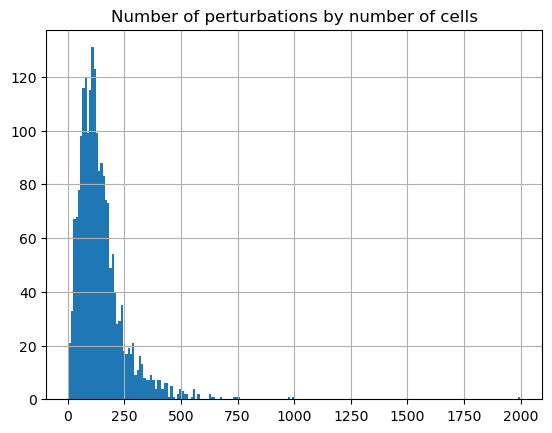

In [15]:
adata[adata.obs["gene"] != "non-targeting"].obs["gene"].value_counts().hist(bins=200)
plt.title("Number of perturbations by number of cells")
plt.show()

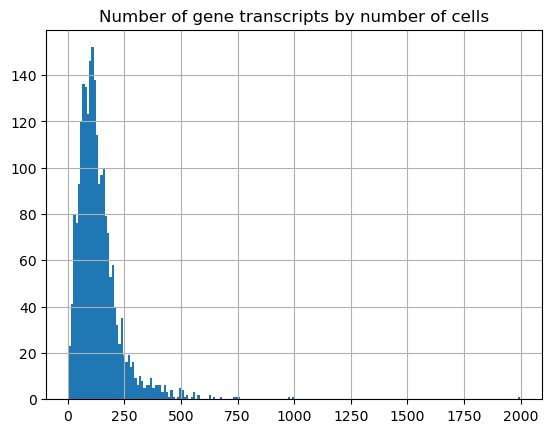

In [16]:
adata[adata.obs["gene_transcript"] != "non-targeting"].obs[
    "gene_transcript"
].value_counts().hist(bins=200)
plt.title("Number of gene transcripts by number of cells")
plt.show()

In [20]:
sc.pp.filter_cells(adata, min_counts=100)
sc.pp.filter_genes(adata, min_cells=100)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [22]:
# get perturbation genes
pert_list = set()
for t in adata.obs["gene"]:
    if "+" not in t and t != "non-targeting":
        pert_list.add(t)

2057

In [23]:
# subset to hvg
sc.pp.highly_variable_genes(adata, n_top_genes=5000, subset=False)

In [26]:
# ensure all perts are in adata
idx = []
for i in range(len(adata.var_names)):
    if (adata.var["highly_variable"][i]) or (adata.var_names[i] in pert_list):
        idx.append(i)
adata_subset = adata[:, idx]
adata_subset

View of AnnData object with n_obs × n_vars = 310385 × 5000
    obs: 'gem_group', 'gene', 'gene_id', 'transcript', 'gene_transcript', 'sgID_AB', 'mitopercent', 'UMI_count', 'z_gemgroup_UMI', 'core_scale_factor', 'core_adjusted_UMI_count'
    var: 'gene_name', 'chr', 'start', 'end', 'class', 'strand', 'length', 'in_matrix', 'mean', 'std', 'cv', 'fano', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## StringDB prior graph

In [29]:
# stringdb prior
stringdb_hq = read_aws_csv("s3://pert-spectra/references/StringDB.HQ.txt", sep="\t")

In [31]:
# ensg mapping
gene_name_df = read_aws_csv(
    "s3://pert-spectra/references/Homo_sapiens.gene_info", sep="\t"
)

In [32]:
gene_name_df

,#tax_id,GeneID,Symbol,LocusTag,Synonyms,dbXrefs,chromosome,map_location,description,type_of_gene,Symbol_from_nomenclature_authority,Full_name_from_nomenclature_authority,Nomenclature_status,Other_designations,Modification_date,Feature_type
0,9606,1,A1BG,-,A1B|ABG|GAB|HYST2477,MIM:138670|HGNC:HGNC:5|Ensembl:ENSG00000121410...,19,19q13.43,alpha-1-B glycoprotein,protein-coding,A1BG,alpha-1-B glycoprotein,O,alpha-1B-glycoprotein|HEL-S-163pA|epididymis s...,20240617,-
1,9606,2,A2M,-,A2MD|CPAMD5|FWP007|S863-7,MIM:103950|HGNC:HGNC:7|Ensembl:ENSG00000175899...,12,12p13.31,alpha-2-macroglobulin,protein-coding,A2M,alpha-2-macroglobulin,O,alpha-2-macroglobulin|C3 and PZP-like alpha-2-...,20240617,-
2,9606,3,A2MP1,-,A2MP,HGNC:HGNC:8|Ensembl:ENSG00000291190|AllianceGe...,12,12p13.31,alpha-2-macroglobulin pseudogene 1,pseudo,A2MP1,alpha-2-macroglobulin pseudogene 1,O,pregnancy-zone protein pseudogene,20240617,-
3,9606,9,NAT1,-,AAC1|MNAT|NAT-1|NATI,MIM:108345|HGNC:HGNC:7645|Ensembl:ENSG00000171...,8,8p22,N-acetyltransferase 1,protein-coding,NAT1,N-acetyltransferase 1,O,arylamine N-acetyltransferase 1|N-acetyltransf...,20240617,-
4,9606,10,NAT2,-,AAC2|NAT-2|PNAT,MIM:612182|HGNC:HGNC:7646|Ensembl:ENSG00000156...,8,8p22,N-acetyltransferase 2,protein-coding,NAT2,N-acetyltransferase 2,O,arylamine N-acetyltransferase 2|N-acetyltransf...,20240617,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193451,741158,8923215,trnD,-,-,-,MT,-,tRNA-Asp,tRNA,-,-,-,-,20200909,-
193452,741158,8923216,trnP,-,-,-,MT,-,tRNA-Pro,tRNA,-,-,-,-,20200909,-
193453,741158,8923217,trnA,-,-,-,MT,-,tRNA-Ala,tRNA,-,-,-,-,20200909,-
193454,741158,8923218,COX1,-,-,-,MT,-,cytochrome c oxidase subunit I,protein-coding,-,-,-,cytochrome c oxidase subunit I,20230818,-


In [49]:
gene_to_ensg = {}
gene_name_mapping = {}
for symbol, synonyms, ref in zip(
    gene_name_df["Symbol"], gene_name_df["Synonyms"], gene_name_df["dbXrefs"]
):
    syn_set = set(synonyms.split("|")).union(set([symbol]))
    refs = ref.split("|")
    ensg = None
    for r in refs:
        label = r.split(":")
        if label[0] == "Ensembl":
            ensg = label[1]
            break
    if ensg is None:
        continue
    assert ensg[:4] == "ENSG"
    gene_to_ensg[symbol] = ensg
    gene_name_mapping[symbol] = syn_set
    # make sure name mapping goes both ways
    for syn in syn_set:
        if syn in gene_name_mapping:
            gene_name_mapping[syn].add(symbol)
        else:
            gene_name_mapping[syn] = set([symbol])

In [50]:
replogle_ensg_to_gene = {}
for symbol, ensgid in zip(adata_subset.var["gene_name"], adata_subset.var_names):
    replogle_ensg_to_gene[ensgid] = symbol

In [51]:
dataset_measured_genes = set(adata_subset.var["gene_name"])
dataset_measured_ensg = set(adata_subset.var_names)

In [52]:
# first, check if gene name has ensembl id
# if it does, use that to match
# else, use gene name mapping
edges = []
for index, row in stringdb_hq.iterrows():
    gene1 = row["i_genes"]
    gene2 = row["j_genes"]
    if gene1 not in gene_to_ensg:
        # neither gene has ensg
        if gene2 not in gene_to_ensg:
            gene1_syn = set([gene1])
            gene2_syn = set([gene2])
            if gene1 in gene_name_mapping:
                gene1_syn = gene_name_mapping[gene1].union(set([gene1]))
            if gene2 in gene_name_mapping:
                gene2_syn = gene_name_mapping[gene2].union(set([gene2]))

            alias_intersect_1 = gene1_syn.intersection(dataset_measured_genes)
            alias_intersect_2 = gene2_syn.intersection(dataset_measured_genes)

            if (len(alias_intersect_1) > 0) and (len(alias_intersect_2) > 0):
                gene1 = (
                    gene1
                    if gene1 in dataset_measured_genes
                    else list(alias_intersect_1)[0]
                )
                gene2 = (
                    gene2
                    if gene2 in dataset_measured_genes
                    else list(alias_intersect_2)[0]
                )
                edges.append([gene1, gene2, row["x"]])

        # gene1 does not have ensemblid, gene2 does have ensemblid
        else:
            ensg2 = gene_to_ensg[gene2]
            gene1_syn = set([gene1])
            gene2_syn = set([ensg2])
            if gene1 in gene_name_mapping:
                gene1_syn = gene_name_mapping[gene1].union(set([gene1]))

            alias_intersect_1 = gene1_syn.intersection(dataset_measured_genes)
            alias_intersect_2 = gene2_syn.intersection(dataset_measured_ensg)

            if (len(alias_intersect_1) > 0) and (len(alias_intersect_2) > 0):
                gene1 = (
                    gene1
                    if gene1 in dataset_measured_genes
                    else list(alias_intersect_1)[0]
                )
                gene2 = replogle_ensg_to_gene[list(alias_intersect_2)[0]]
                edges.append([gene1, gene2, row["x"]])

    else:
        # gene1 has ensemblid, gene2 does not have ensemblid
        if gene2 not in gene_to_ensg:
            ensg1 = gene_to_ensg[gene1]
            gene1_syn = set([ensg1])
            gene2_syn = set([gene2])
            if gene2 in gene_name_mapping:
                gene2_syn = gene_name_mapping[gene2].union(set([gene2]))

            alias_intersect_1 = gene1_syn.intersection(dataset_measured_ensg)
            alias_intersect_2 = gene2_syn.intersection(dataset_measured_genes)

            if (len(alias_intersect_1) > 0) and (len(alias_intersect_2) > 0):
                gene1 = replogle_ensg_to_gene[list(alias_intersect_1)[0]]
                gene2 = (
                    gene2
                    if gene2 in dataset_measured_genes
                    else list(alias_intersect_2)[0]
                )
                edges.append([gene1, gene2, row["x"]])

        # both genes have ensmblid
        else:
            ensg1 = gene_to_ensg[gene1]
            ensg2 = gene_to_ensg[gene2]
            gene1_syn = set([ensg1])
            gene2_syn = set([ensg2])

            alias_intersect_1 = gene1_syn.intersection(dataset_measured_ensg)
            alias_intersect_2 = gene2_syn.intersection(dataset_measured_ensg)

            if (len(alias_intersect_1) > 0) and (len(alias_intersect_2) > 0):
                gene1 = replogle_ensg_to_gene[list(alias_intersect_1)[0]]
                gene2 = replogle_ensg_to_gene[list(alias_intersect_2)[0]]
                edges.append([gene1, gene2, row["x"]])

In [53]:
replogle_network = pd.DataFrame(edges, columns=["gene1", "gene2", "score"])
replogle_network

,gene1,gene2,score
0,M6PR,ARF5,0.157
1,MIF,ARF5,0.164
2,AP4S1,ARF5,0.250
3,CHMP4B,ARF5,0.327
4,NME4,ARF5,0.212
...,...,...,...
801575,PTGES3,EIF3L,0.150
801576,NR2C2,EIF3L,0.270
801577,NSA2,EIF3L,0.315
801578,PSMB3,EIF3L,0.169


In [57]:
# add genes measured in Replogle with no connections found in StringDB
missing_genes = dataset_measured_genes.difference(
    set(replogle_network["gene1"].unique())
)
for g in missing_genes:
    replogle_network = pd.concat(
        [pd.DataFrame([[g, g, 0]], columns=replogle_network.columns), replogle_network],
        ignore_index=True,
    )
replogle_network

,gene1,gene2,score
0,SEPTIN2,SEPTIN2,0.000
1,ZNF433-AS1,ZNF433-AS1,0.000
2,SLC16A1-AS1,SLC16A1-AS1,0.000
3,AP000873.2,AP000873.2,0.000
4,CHKB-DT,CHKB-DT,0.000
...,...,...,...
802163,PTGES3,EIF3L,0.150
802164,NR2C2,EIF3L,0.270
802165,NSA2,EIF3L,0.315
802166,PSMB3,EIF3L,0.169


In [ ]:
# create one-hot-encoding mapping based on adata var structure
adata_subset.var_names = adata_subset.var["gene_name"]


def map_gene_to_onehot(name: str):
    return adata_subset.var_names.get_loc(name)


replogle_network["gene1"] = replogle_network["gene1"].apply(map_gene_to_onehot)
replogle_network["gene2"] = replogle_network["gene2"].apply(map_gene_to_onehot)
replogle_network = replogle_network.sort_values(by=["gene1"])

In [63]:
# create weighted adj matrix
import networkx

edgeList = replogle_network.values.tolist()
G = networkx.DiGraph()
for i in range(len(edgeList)):
    G.add_edge(edgeList[i][0], edgeList[i][1], weight=edgeList[i][2])
A = networkx.adjacency_matrix(
    G, nodelist=[i for i in range(len(adata_subset.var_names))]
).toarray()

In [65]:
# turn to sparse
from scipy import sparse

sA = sparse.csr_matrix(A)

In [69]:
adata_subset.X = sparse.csr_matrix(adata_subset.X)
adata_subset.layers["logcounts"] = adata_subset.X.copy()

In [70]:
# write to adata
adata_subset.uns["sparse_gene_network"] = sA
adata_subset.write_h5ad("../replogle_adata_spectra.h5ad")